<a href="https://colab.research.google.com/github/ZhangEnsure/pytorch-d2l-zh/blob/master/3.%E7%8E%B0%E4%BB%A3%E5%8D%B7%E7%A7%AF%E7%A5%9E%E7%BB%8F%E7%BD%91%E7%BB%9C/batch_norm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 批量规范化

从零实现

In [ ]:
%pip install d2l
%pip install matplotlib_inline
%pip install matplotlib==3.0

In [3]:
import torch
from torch import nn
from d2l import torch as d2l


def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
  # 预测模式
  if not torch.is_grad_enabled():
    # eps 是为了防止方差为0的除0情况的发生
    X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
  # 训练模式
  else:
    # 一种就是全连接层=2，另外一种就是2d卷积=4
    assert len(X.shape) in (2, 4)
    # 全连接层而言，每一行是一个样本，样本的每一列是一种特征
    if len(X.shape) == 2:
      # 跨行(对同一列元素)求均值
      # 均值和方差在这里都是向量的形式
      mean = X.mean(dim=0)
      var = ((X - mean) ** 2).mean(dim=0)
    else:
      mean = X.mean(dim=(0, 2, 3), keepdim=True)
      var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)
    X_hat = (X - mean) / torch.sqrt(var + eps)
    moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
    moving_var = momentum * moving_var + (1.0 - momentum) * var
  Y = gamma * X_hat + beta
  return Y, moving_mean.data, moving_var.data

创建一个正确的`BatchNorm`层

In [6]:
class BatchNorm(nn.Module):
  def __init__(self, num_features, num_dims):
    super().__init__()
    if num_dims == 2:
      shape = (1, num_features)
    else:
      shape = (1, num_features, 1, 1)
    self.gamma = nn.Parameter(torch.ones(shape))
    self.beta = nn.Parameter(torch.zeros(shape))
    self.moving_mean = torch.zeros(shape)
    self.moving_var = torch.ones(shape)

  def forward(self, X):
    # moving_mean 和 moving_var 不是 nn.Parameter()定义的参数
    # 所以需要手动移动到 gpu 上计算
    if self.moving_mean.device != X.device:
      self.moving_mean = self.moving_mean.to(X.device)
      self.moving_var = self.moving_var.to(X.device)
    Y, self.moving_mean, self.moving_var = batch_norm(
      X, self.gamma, self.beta, self.moving_mean,
      self.moving_var, eps=1e-5, momentum=0.9)
    return Y

应用`BatchNorm`
于LeNet模型

In [7]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), BatchNorm(6, num_dims=4), 
    nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), BatchNorm(16, num_dims=4), 
    nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(16*4*4, 120), BatchNorm(120, num_dims=2), 
    nn.Sigmoid(),
    nn.Linear(120, 84), BatchNorm(84, num_dims=2), 
    nn.Sigmoid(),
    nn.Linear(84, 10))

In [10]:
from google.colab import drive
drive.mount('/content/drive')
import torchvision
from torchvision import transforms 
from torch.utils import data

def load_data_fashion_mnist(batch_size, resize=None):
  """下载Fashion-MNIST数据集，然后将其加载到内存中
  Defined in :numref:`sec_fashion_mnist`"""
  trans = [transforms.ToTensor()]
  if resize:
      trans.insert(0, transforms.Resize(resize))
  trans = transforms.Compose(trans)
  mnist_train = torchvision.datasets.FashionMNIST(
      root="./drive/MyDrive/Notebooks/data", train=True, transform=trans, download=True)
  mnist_test = torchvision.datasets.FashionMNIST(
      root="./drive/MyDrive/Notebooks/data", train=False, transform=trans, download=True)
  return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                          num_workers=2),
          data.DataLoader(mnist_test, batch_size, shuffle=False,
                          num_workers=2))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


在Fashion-MNIST数据集上训练网络

In [11]:
lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)

loss 0.290, train acc 0.893, test acc 0.827
21189.4 examples/sec on cuda:0


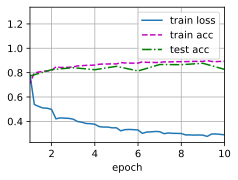

In [12]:
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

拉伸参数`gamma`和偏移参数`beta`

In [13]:
net[1].gamma.reshape((-1,)), net[1].beta.reshape((-1,))

(tensor([0.3168, 3.9548, 0.4808, 4.2327, 2.7800, 0.8388], device='cuda:0',
        grad_fn=<ReshapeAliasBackward0>),
 tensor([-0.1841, -2.5287, -0.1323, -4.4513,  1.3335,  1.2856], device='cuda:0',
        grad_fn=<ReshapeAliasBackward0>))

简明实现

In [14]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), 
    nn.BatchNorm2d(6), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), 
    nn.BatchNorm2d(16), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(256, 120), 
    nn.BatchNorm1d(120), nn.Sigmoid(),
    nn.Linear(120, 84), 
    nn.BatchNorm1d(84), nn.Sigmoid(),
    nn.Linear(84, 10))

使用相同超参数来训练模型

loss 0.272, train acc 0.900, test acc 0.841
41455.5 examples/sec on cuda:0


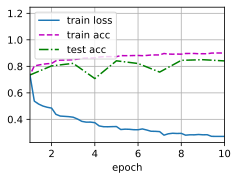

In [15]:
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())